In [1]:
import sys, glob, os
sys.path.extend(glob.glob(os.path.join(os.path.expanduser("~"), ".ivy2/jars/*.jar")))
from sparkdl import readImages
from pyspark.sql.functions import lit

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
img_dir = "hdfs:///flower-classify/flowers"

#Read images and Create training & test DataFrames for transfer learning
daisy_df = readImages(img_dir + "/daisy").withColumn("label", lit(0))
dandelion_df = readImages(img_dir + "/dandelion").withColumn("label", lit(1))
roses_df = readImages(img_dir + "/roses").withColumn("label", lit(2))
sunflowers_df = readImages(img_dir + "/sunflowers").withColumn("label", lit(3))
tulips_df = readImages(img_dir + "/tulips").withColumn("label", lit(4))
print("DATA READ.")

daisy_train, daisy_test = daisy_df.randomSplit([0.6, 0.4])
dandelion_train, dandelion_test = dandelion_df.randomSplit([0.6, 0.4])
roses_train, roses_test = roses_df.randomSplit([0.6, 0.4])
sunflowers_train, sunflowers_test = sunflowers_df.randomSplit([0.6, 0.4])
tulips_train, tulips_test = tulips_df.randomSplit([0.6, 0.4])
print("DATA SPLITTED.")

#dataframe for training a classification model
train_df = daisy_train.unionAll(dandelion_train).unionAll(roses_train).unionAll(sunflowers_train).unionAll(tulips_train)
print("TRAIN DF PREPARED.")

#dataframe for testing the classification model
test_df = daisy_test.unionAll(dandelion_test).unionAll(roses_test).unionAll(sunflowers_test).unionAll(tulips_test)
print("TEST DF PREPARED.")

DATA READ.
DATA SPLITTED.
TRAIN DF PREPARED.
TEST DF PREPARED.


In [10]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer

featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")
lr = LogisticRegression(maxIter=20, regParam=0.05, elasticNetParam=0.3, labelCol="label")
p = Pipeline(stages=[featurizer, lr])
p_model = p.fit(train_df)

INFO:tensorflow:Froze 376 variables.
Converted 376 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In [11]:
#from pyspark.ml.evaluation import MulticlassClassificationEvaluator

df = p_model.transform(test_df)
pandas_df = df.toPandas()
#df.cache()
#df.show()
#predictionAndLabels = df.select("prediction", "label")
#evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
#print("Training set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

INFO:tensorflow:Froze 376 variables.
Converted 376 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|            filePath|               image|label|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|hdfs://student11:...|[RGB,222,240,3,[B...|    0|[0.0,0.0,1.267154...|[4.15220163147127...|[0.89653073829356...|       0.0|
|hdfs://student11:...|[RGB,240,320,3,[B...|    0|[0.0,0.3683027625...|[3.18214258197736...|[0.71618489426497...|       0.0|
|hdfs://student11:...|[RGB,221,320,3,[B...|    0|[0.0,0.0,0.0,0.0,...|[4.92990246623436...|[0.95854528426993...|       0.0|
|hdfs://student11:...|[RGB,240,320,3,[B...|    0|[0.0,1.3719514608...|[4.23105844658709...|[0.92017716930697..

In [64]:
import pandas as pd
from pandas_ml import ConfusionMatrix

confusion_matrix = ConfusionMatrix(pandas_df.label, pandas_df.prediction)
print('Training set accuracy: ' + str(confusion_matrix.stats()['overall']['Accuracy']))
pandas_df[0:10]

Training set accuracy: 0.8718813216453135


,filePath,image,label,features,rawPrediction,probability,prediction
0,hdfs://student11:9000/flower-classify/flowers/...,"(RGB, 222, 240, 3, [0, 2, 0, 34, 40, 14, 76, 8...",0,"[0.0, 0.0, 1.2671546936035156, 0.0, 0.00311020...","[4.152201631471271, 0.8492271885455698, -0.832...","[0.89653073829356, 0.03296868384560222, 0.0061...",0.0
1,hdfs://student11:9000/flower-classify/flowers/...,"(RGB, 240, 320, 3, [0, 0, 0, 1, 1, 1, 2, 2, 2,...",0,"[0.0, 0.36830276250839233, 0.0, 0.0, 0.4753233...","[3.1821425819773683, 0.6997023138625973, -0.25...","[0.716184894264979, 0.05982945497041147, 0.022...",0.0
2,hdfs://student11:9000/flower-classify/flowers/...,"(RGB, 221, 320, 3, [0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,"[0.0, 0.0, 0.0, 0.0, 1.1911736726760864, 1.488...","[4.929902466234366, 0.5313858243063282, -0.343...","[0.9585452842699334, 0.011785855951924593, 0.0...",0.0
3,hdfs://student11:9000/flower-classify/flowers/...,"(RGB, 240, 320, 3, [14, 7, 0, 15, 8, 2, 17, 10...",0,"[0.0, 1.3719514608383179, 0.29387155175209045,...","[4.231058446587093, 0.7499814644733906, -0.513...","[0.920177169306975, 0.02831776212583524, 0.008...",0.0
4,hdfs://student11:9000/flower-classify/flowers/...,"(RGB, 240, 180, 3, [188, 204, 141, 191, 205, 1...",0,"[0.0, 0.0, 0.0, 0.015875697135925293, 0.0, 0.0...","[5.385266310907781, 0.7692968654192338, -0.834...","[0.9782597399455417, 0.00967752098647648, 0.00...",0.0
5,hdfs://student11:9000/flower-classify/flowers/...,"(RGB, 281, 500, 3, [2, 2, 0, 2, 2, 0, 2, 2, 0,...",0,"[0.0, 0.39259788393974304, 1.7951748371124268,...","[4.279432347203607, 1.7101340840024835, -0.423...","[0.8592565023658101, 0.0658098300473548, 0.007...",0.0
6,hdfs://student11:9000/flower-classify/flowers/...,"(RGB, 326, 500, 3, [1, 3, 2, 0, 2, 1, 0, 2, 1,...",0,"[1.5086427927017212, 0.24447858333587646, 0.76...","[4.950016409804035, 1.0512349980980558, -1.064...","[0.9529345058118684, 0.019312735820619247, 0.0...",0.0
7,hdfs://student11:9000/flower-classify/flowers/...,"(RGB, 292, 500, 3, [76, 81, 59, 77, 82, 62, 77...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14196118...","[4.135508234717649, 0.7022178704490376, -0.393...","[0.8849328062269627, 0.02856611864196149, 0.00...",0.0
8,hdfs://student11:9000/flower-classify/flowers/...,"(RGB, 240, 240, 3, [37, 66, 8, 34, 65, 8, 32, ...",0,"[0.0, 0.5098966360092163, 0.0, 0.0, 0.07169315...","[4.663936919585464, 0.6612608137418883, -0.753...","[0.9509825632378979, 0.017371303512719052, 0.0...",0.0
9,hdfs://student11:9000/flower-classify/flowers/...,"(RGB, 240, 320, 3, [106, 113, 105, 122, 127, 1...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10533631...","[5.278388812940436, 0.5878836506734482, -0.956...","[0.96963434410909, 0.00890322769476673, 0.0019...",0.0


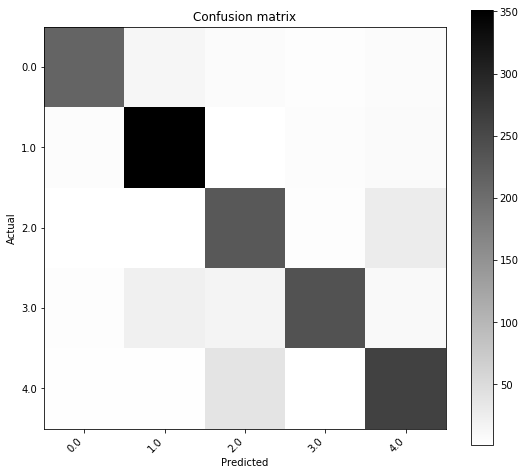

In [65]:
import matplotlib.pyplot as plt
confusion_matrix.plot()
plt.show()

In [62]:
confusion_matrix.print_stats()

Confusion Matrix:

Predicted  0.0  1.0  2.0  3.0  4.0  __all__
Actual                                     
0.0        213   14    7    5    7      246
1.0          6  351    1    6    9      373
2.0          2    2  230    5   27      266
3.0          4   22   17  237   10      290
4.0          3    3   39    1  262      308
__all__    228  392  294  254  315     1483


Overall Statistics:

Accuracy: 0.8718813216453135
95% CI: (0.853795254319396, 0.888479527668066)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.0
Kappa: 0.8388136612243798
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                      0.0        1.0        2.0  \
Population                                  1483       1483       1483   
P: Condition positive                        246        373        266   
N: Condition negative                       1237       1110       1217   
Test outcome positive                        228        392        294   
Test outcome negative            